In [1]:
import numpy as np

kB = 8.617333262e-5  # eV/K


def sample_barriers(N, mu, sigma, dist="gaussian"):
    if dist == "gaussian":
        return np.random.normal(mu, sigma, size=N)
    elif dist == "exponential":
        return np.random.exponential(mu, size=N)
    else:
        raise ValueError("Unknown distribution")

def arrhenius_rate(barrier, T, tau0=1e-12, stress=0.0, Omega=0.0):
    effective_barrier = barrier - stress * Omega
    return (1.0 / tau0) * np.exp(-effective_barrier / (kB * T))

def sample_waiting_time(rate):
    return np.random.exponential(1.0 / rate)

def simulate_line_velocity(
    N=50,
    L=1.0,
    b=1.0,
    T=300,
    stress=0.0,
    mu_n=0.8,
    sig_n=0.1,
    mu_p=0.4,
    sig_p=0.05,
    steps=10000
):
    # Sample barriers
    Gn = sample_barriers(N+1, mu_n, sig_n)
    Gp = sample_barriers(N, mu_p, sig_p)

    # Rates
    lambda_n = arrhenius_rate(Gn, T, stress=stress, Omega=1.0)
    lambda_p = arrhenius_rate(Gp, T, stress=stress, Omega=0.5)

    time = 0.0
    displacement = 0.0

    for _ in range(steps):
        # Nucleation event
        tn = np.min(np.random.exponential(1.0 / lambda_n))

        # Propagation through all segments
        tp = np.sum(np.random.exponential(1.0 / lambda_p))

        dt = tn + tp
        time += dt
        displacement += b

    return displacement / time


In [2]:
velocities = [simulate_line_velocity() for _ in range(50)]

print("Mean velocity:", np.mean(velocities))
print("Std velocity:", np.std(velocities))


Mean velocity: 242.3341222065944
Std velocity: 196.39196319529992


In [3]:
import numpy as np

kB = 8.617333262e-5  # eV/K

def arrhenius_rate(barrier, T, tau0=1e-12, stress=0.0, Omega=0.0):
    eff = barrier - stress * Omega
    return (1.0 / tau0) * np.exp(-eff / (kB * T))


def simulate_line_with_diagnostics(
    N=50,
    b=1.0,
    T=300,
    stress=0.0,
    mu_n=0.8,
    sig_n=0.1,
    mu_p=0.4,
    sig_p=0.05,
    steps=2000
):
    # --- Sample barriers ---
    Gn = np.random.normal(mu_n, sig_n, size=N+1)
    Gp = np.random.normal(mu_p, sig_p, size=N)

    # --- Compute rates ---
    lambda_n = arrhenius_rate(Gn, T, stress=stress, Omega=1.0)
    lambda_p = arrhenius_rate(Gp, T, stress=stress, Omega=0.5)

    # --- Diagnostics ---
    time = 0.0
    displacement = 0.0
    node_displacement = np.zeros(N+1)
    nucleation_counts = np.zeros(N+1)

    for _ in range(steps):
        # pick nucleation site
        probs = lambda_n / np.sum(lambda_n)
        node = np.random.choice(N+1, p=probs)

        # waiting times
        tn = np.random.exponential(1.0 / lambda_n[node])
        tp = np.sum(np.random.exponential(1.0 / lambda_p))

        dt = tn + tp
        time += dt

        # update displacement
        displacement += b
        node_displacement[node] += b
        nucleation_counts[node] += 1

    velocity = displacement / time

    return {
        "Gn": Gn,
        "Gp": Gp,
        "lambda_n": lambda_n,
        "lambda_p": lambda_p,
        "node_displacement": node_displacement,
        "nucleation_counts": nucleation_counts,
        "velocity": velocity
    }


In [5]:
import matplotlib.pyplot as plt

def plot_barrier_distributions(Gn, Gp, mu_n, sig_n, mu_p, sig_p):
    x_n = np.linspace(mu_n - 4*sig_n, mu_n + 4*sig_n, 400)
    x_p = np.linspace(mu_p - 4*sig_p, mu_p + 4*sig_p, 400)

    pdf_n = (1/(sig_n*np.sqrt(2*np.pi))) * np.exp(-(x_n-mu_n)**2/(2*sig_n**2))
    pdf_p = (1/(sig_p*np.sqrt(2*np.pi))) * np.exp(-(x_p-mu_p)**2/(2*sig_p**2))

    plt.figure(figsize=(6,4))
    plt.hist(Gn, bins=30, density=True, alpha=0.6, label="Sampled nucleation")
    plt.plot(x_n, pdf_n, 'k--', label="Input nucleation PDF")

    plt.hist(Gp, bins=30, density=True, alpha=0.6, label="Sampled propagation")
    plt.plot(x_p, pdf_p, 'r--', label="Input propagation PDF")

    plt.xlabel("Barrier energy (eV)")
    plt.ylabel("Probability density")
    plt.legend()
    plt.title("Barrier Distributions")
    plt.tight_layout()
    plt.show()

def plot_rate_distributions(lambda_n, lambda_p):
    plt.figure(figsize=(6,4))
    plt.hist(lambda_n, bins=30, log=True, alpha=0.6, label="Nucleation rates")
    plt.hist(lambda_p, bins=30, log=True, alpha=0.6, label="Propagation rates")
    plt.xlabel("Rate (1/s)")
    plt.ylabel("Count (log)")
    plt.legend()
    plt.title("Arrhenius Rate Distributions")
    plt.tight_layout()
    plt.show()

def plot_node_displacement(node_displacement):
    nodes = np.arange(len(node_displacement))

    plt.figure(figsize=(6,4))
    plt.bar(nodes, node_displacement)
    plt.xlabel("Node index")
    plt.ylabel("Accumulated displacement")
    plt.title("Node-wise Line Advancement")
    plt.tight_layout()
    plt.show()

def plot_nucleation_counts(nucleation_counts):
    plt.figure(figsize=(6,4))
    plt.plot(nucleation_counts, 'o-')
    plt.xlabel("Node index")
    plt.ylabel("Nucleation events")
    plt.title("Nucleation Activity Along the Line")
    plt.tight_layout()
    plt.show()


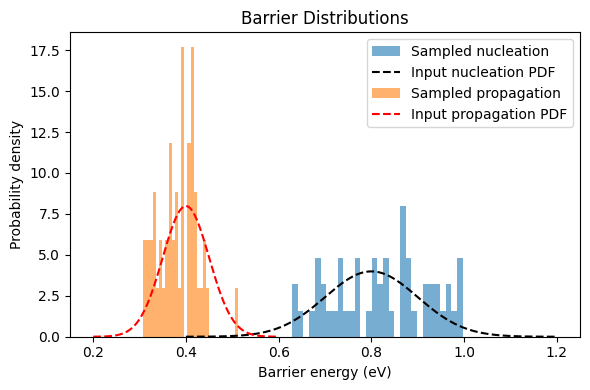

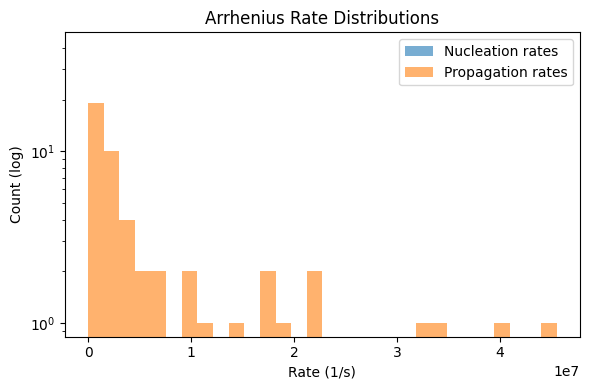

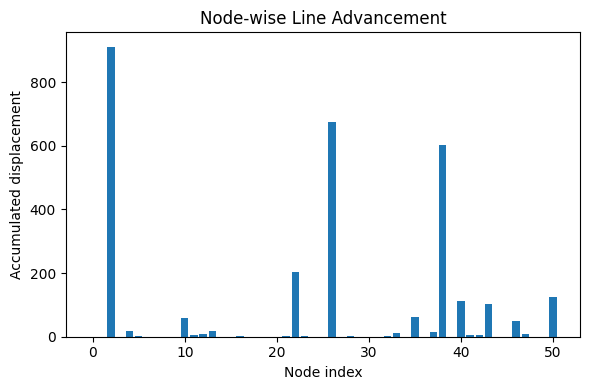

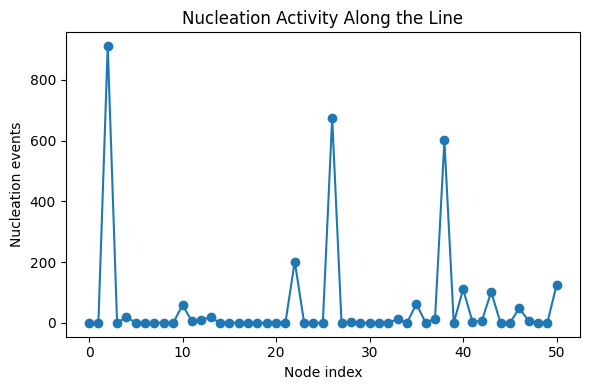

Measured velocity: 117.20058759704757


In [6]:

data = simulate_line_with_diagnostics(
    N=50,
    T=300,
    stress=0.1,
    mu_n=0.8,
    sig_n=0.1,
    mu_p=0.4,
    sig_p=0.05,
    steps=3000
)

plot_barrier_distributions(
    data["Gn"], data["Gp"],
    mu_n=0.8, sig_n=0.1,
    mu_p=0.4, sig_p=0.05
)

plot_rate_distributions(
    data["lambda_n"],
    data["lambda_p"]
)

plot_node_displacement(data["node_displacement"])
plot_nucleation_counts(data["nucleation_counts"])

print("Measured velocity:", data["velocity"])


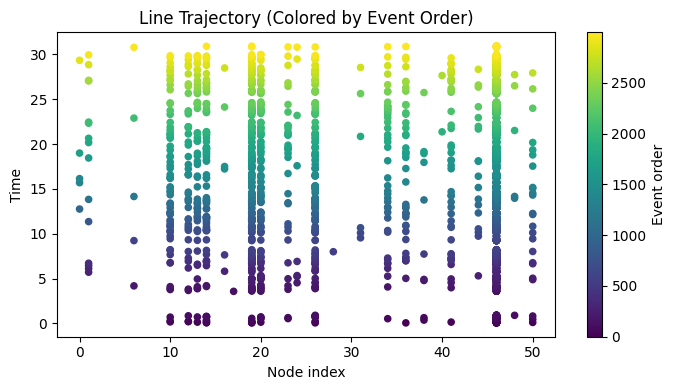

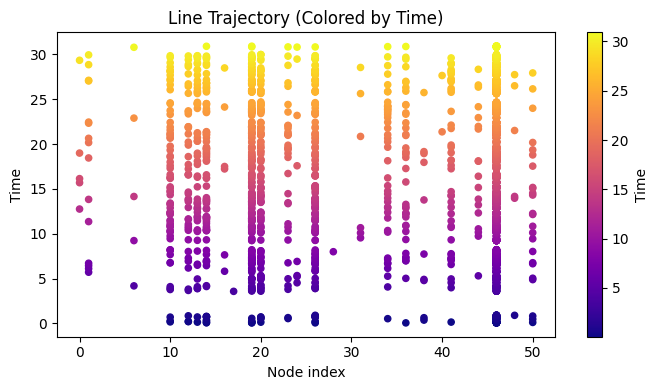

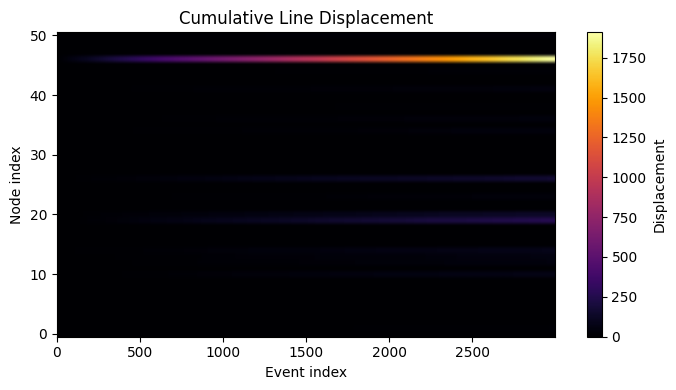

In [7]:
def simulate_line_with_trajectory(
    N=50,
    b=1.0,
    T=300,
    stress=0.0,
    mu_n=0.8,
    sig_n=0.1,
    mu_p=0.4,
    sig_p=0.05,
    steps=2000
):
    # Barriers
    Gn = np.random.normal(mu_n, sig_n, size=N+1)
    Gp = np.random.normal(mu_p, sig_p, size=N)

    # Rates
    lambda_n = arrhenius_rate(Gn, T, stress=stress, Omega=1.0)
    lambda_p = arrhenius_rate(Gp, T, stress=stress, Omega=0.5)

    # State
    time = 0.0
    node_positions = np.zeros(N+1)

    # Trajectory storage
    event_times = []
    event_nodes = []
    event_positions = []
    event_order = []

    for step in range(steps):
        # Choose nucleation site
        probs = lambda_n / np.sum(lambda_n)
        node = np.random.choice(N+1, p=probs)

        # Waiting times
        tn = np.random.exponential(1.0 / lambda_n[node])
        tp = np.sum(np.random.exponential(1.0 / lambda_p))

        dt = tn + tp
        time += dt

        # Update line (simple: whole line advances by b)
        node_positions[node] += b

        # Record event
        event_times.append(time)
        event_nodes.append(node)
        event_positions.append(node_positions[node])
        event_order.append(step)

    return {
        "event_times": np.array(event_times),
        "event_nodes": np.array(event_nodes),
        "event_positions": np.array(event_positions),
        "event_order": np.array(event_order),
        "Gn": Gn,
        "Gp": Gp,
        "lambda_n": lambda_n,
        "lambda_p": lambda_p,
    }

    import matplotlib.pyplot as plt

def plot_line_trajectory(events):
    nodes = events["event_nodes"]
    times = events["event_times"]
    order = events["event_order"]

    plt.figure(figsize=(7,4))
    sc = plt.scatter(
        nodes,
        times,
        c=order,
        cmap="viridis",
        s=20
    )

    plt.xlabel("Node index")
    plt.ylabel("Time")
    plt.title("Line Trajectory (Colored by Event Order)")
    cbar = plt.colorbar(sc)
    cbar.set_label("Event order")

    plt.tight_layout()
    plt.show()


def plot_line_trajectory_time_colored(events):
    nodes = events["event_nodes"]
    times = events["event_times"]

    plt.figure(figsize=(7,4))
    sc = plt.scatter(
        nodes,
        times,
        c=times,
        cmap="plasma",
        s=20
    )

    plt.xlabel("Node index")
    plt.ylabel("Time")
    plt.title("Line Trajectory (Colored by Time)")
    cbar = plt.colorbar(sc)
    cbar.set_label("Time")

    plt.tight_layout()
    plt.show()


def plot_displacement_heatmap(events, N):
    # Build displacement history
    disp = np.zeros(N+1)
    disp_history = []

    for node in events["event_nodes"]:
        disp[node] += 1.0
        disp_history.append(disp.copy())

    disp_history = np.array(disp_history)

    plt.figure(figsize=(7,4))
    plt.imshow(
        disp_history.T,
        aspect="auto",
        origin="lower",
        cmap="inferno"
    )

    plt.xlabel("Event index")
    plt.ylabel("Node index")
    plt.title("Cumulative Line Displacement")
    cbar = plt.colorbar()
    cbar.set_label("Displacement")

    plt.tight_layout()
    plt.show()


events = simulate_line_with_trajectory(
    N=50,
    T=300,
    stress=0.1,
    steps=3000
)

plot_line_trajectory(events)
plot_line_trajectory_time_colored(events)
plot_displacement_heatmap(events, N=50)



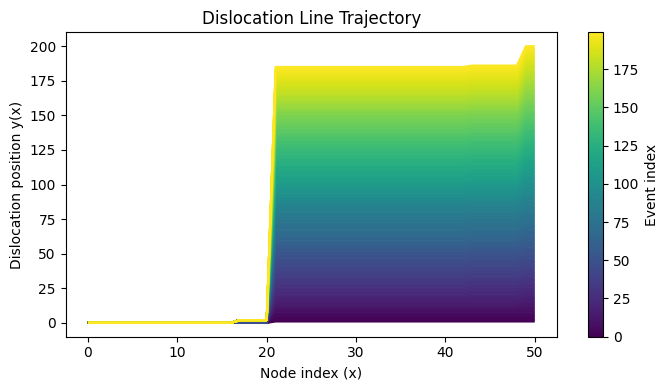

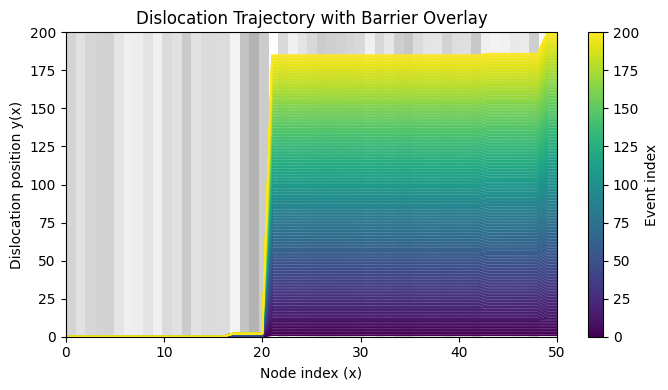

In [10]:
def simulate_line_with_snapshots(
    N=50,
    b=1.0,
    T=300,
    stress=0.0,
    mu_n=0.8,
    sig_n=0.1,
    mu_p=0.4,
    sig_p=0.05,
    steps=500
):
    # Geometry
    x = np.arange(N+1)

    # Barriers
    Gn = np.random.normal(mu_n, sig_n, size=N+1)
    Gp = np.random.normal(mu_p, sig_p, size=N)

    # Rates
    lambda_n = arrhenius_rate(Gn, T, stress=stress, Omega=1.0)
    lambda_p = arrhenius_rate(Gp, T, stress=stress, Omega=0.5)

    # Line state
    y = np.zeros(N+1)

    # Storage
    y_snapshots = []
    event_times = []

    time = 0.0

    for step in range(steps):
        # Choose nucleation site
        probs = lambda_n / np.sum(lambda_n)
        node = np.random.choice(N+1, p=probs)

        # Waiting times
        tn = np.random.exponential(1.0 / lambda_n[node])
        tp = np.sum(np.random.exponential(1.0 / lambda_p))
        time += tn + tp

        # Advance line locally
        y[node:] += b   # kink sweeps right for simplicity

        # Record snapshot
        y_snapshots.append(y.copy())
        event_times.append(time)

    return {
        "x": x,
        "y_snapshots": np.array(y_snapshots),
        "event_times": np.array(event_times),
        "Gn": Gn,
        "Gp": Gp
    }

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm

def plot_line_trajectory_colored(x, y_snapshots):
    num_steps = y_snapshots.shape[0]

    # Build line segments
    segments = []
    colors = []

    for k in range(num_steps):
        points = np.column_stack((x, y_snapshots[k]))
        segments.append(points)
        colors.append(k)

    lc = LineCollection(
        segments,
        cmap="viridis",
        linewidths=1.5
    )
    lc.set_array(np.array(colors))

    plt.figure(figsize=(7,4))
    plt.gca().add_collection(lc)
    plt.autoscale()

    plt.xlabel("Node index (x)")
    plt.ylabel("Dislocation position y(x)")
    plt.title("Dislocation Line Trajectory")

    cbar = plt.colorbar(lc)
    cbar.set_label("Event index")

    plt.tight_layout()
    plt.show()


def plot_line_with_barrier_background(x, y_snapshots, Gn):
    num_steps = y_snapshots.shape[0]

    # Background barrier field
    plt.figure(figsize=(7,4))
    plt.imshow(
        Gn[np.newaxis, :],
        extent=[x.min(), x.max(), 
                y_snapshots.min(), y_snapshots.max()],
        aspect="auto",
        cmap="Greys",
        alpha=0.3,
        origin="lower"
    )

    # Line snapshots
    for k in range(num_steps):
        plt.plot(
            x,
            y_snapshots[k],
            color=cm.viridis(k / num_steps),
            linewidth=1.2
        )

    plt.xlabel("Node index (x)")
    plt.ylabel("Dislocation position y(x)")
    plt.title("Dislocation Trajectory with Barrier Overlay")

    cbar = plt.colorbar(
        cm.ScalarMappable(
            cmap="viridis",
            norm=plt.Normalize(0, num_steps)
        ),
        ax=plt.gca()
    )
    cbar.set_label("Event index")

    plt.tight_layout()
    plt.show()

def plot_line_with_barrier_markers(x, y_snapshots, Gn):
    plt.figure(figsize=(7,4))

    # Final line shape
    y_final = y_snapshots[-1]

    sc = plt.scatter(
        x,
        y_final,
        c=Gn,
        cmap="inferno",
        s=50,
        zorder=3
    )

    # Trajectory
    for k in range(len(y_snapshots)):
        plt.plot(
            x,
            y_snapshots[k],
            color=cm.viridis(k / len(y_snapshots)),
            alpha=0.3
        )

    plt.xlabel("Node index (x)")
    plt.ylabel("Dislocation position y(x)")
    plt.title("Final Line with Barrier Strength")

    cbar = plt.colorbar(sc)
    cbar.set_label("Barrier energy (eV)")

    plt.tight_layout()
    plt.show()

data = simulate_line_with_snapshots(
    N=50,
    T=300,
    stress=0.1,
    steps=200
)

plot_line_trajectory_colored(
    data["x"],
    data["y_snapshots"]
)

plot_line_with_barrier_background(
    data["x"],
    data["y_snapshots"],
    data["Gn"]
)


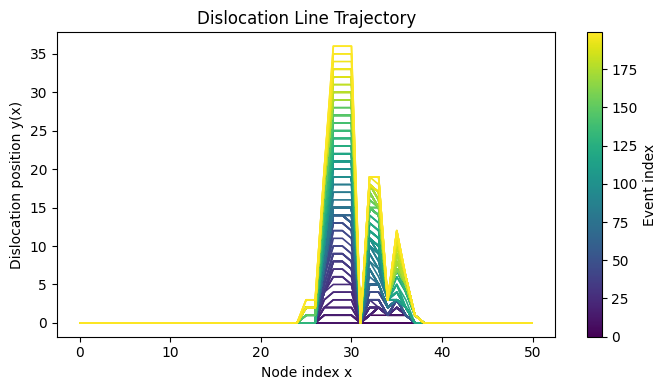

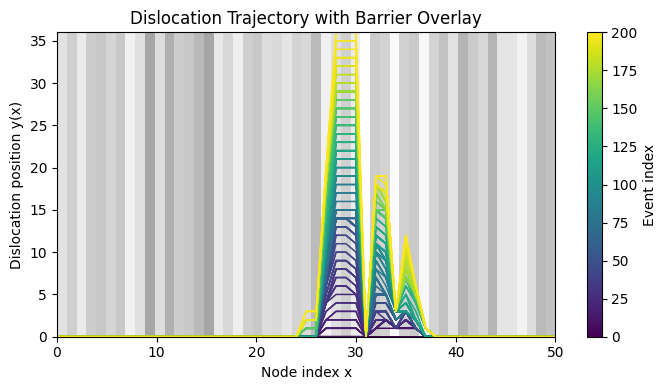

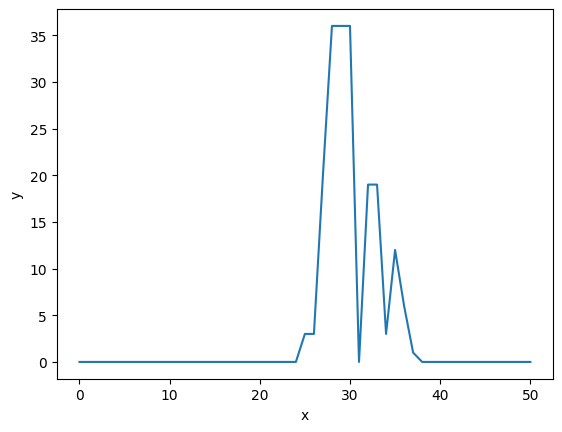

y min/max: 0.0 36.0


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm

kB = 8.617333262e-5  # eV/K

def arrhenius_rate(barrier, T, tau0=1e-12, stress=0.0, Omega=0.0):
    eff = barrier - stress * Omega
    return (1.0 / tau0) * np.exp(-eff / (kB * T))

def sample_barriers(N, mu, sigma):
    return np.random.normal(mu, sigma, size=N)

def propagate_kink(
    y,
    node,
    Gp,
    T,
    stress,
    b,
    Omega_p=0.5
):
    N = len(y) - 1

    # --- Right propagation ---
    for j in range(node, N):
        p_continue = np.exp(-(Gp[j] - stress * Omega_p) / (kB * T))
        if np.random.rand() < p_continue:
            y[j+1] += b
        else:
            break

    # --- Left propagation ---
    for j in range(node-1, -1, -1):
        p_continue = np.exp(-(Gp[j] - stress * Omega_p) / (kB * T))
        if np.random.rand() < p_continue:
            y[j] += b
        else:
            break


def simulate_line_option3(
    N=50,
    b=1.0,
    T=300,
    stress=0.1,
    mu_n=0.2,
    sig_n=0.1,
    mu_p=0.05,
    sig_p=0.05,
    steps=300
):
    # Geometry
    x = np.arange(N+1)

    # Barriers
    Gn = sample_barriers(N+1, mu_n, sig_n)
    Gp = sample_barriers(N,   mu_p, sig_p)

    # Nucleation rates
    lambda_n = arrhenius_rate(Gn, T, stress=stress, Omega=1.0)

    # Line state
    y = np.zeros(N+1)

    # Storage
    y_snapshots = []
    event_times = []

    time = 0.0

    for step in range(steps):
        # Choose nucleation site
        probs = lambda_n / np.sum(lambda_n)
        node = np.random.choice(N+1, p=probs)

        # Nucleation waiting time
        tn = np.random.exponential(1.0 / lambda_n[node])
        time += tn

        # Propagate kink
        propagate_kink(y, node, Gp, T, stress, b)

        # Record
        y_snapshots.append(y.copy())
        event_times.append(time)

    return {
        "x": x,
        "y_snapshots": np.array(y_snapshots),
        "event_times": np.array(event_times),
        "Gn": Gn,
        "Gp": Gp
    }

def plot_line_trajectory_colored(x, y_snapshots):
    segments = []
    colors = []

    for k in range(len(y_snapshots)):
        pts = np.column_stack((x, y_snapshots[k]))
        segments.append(pts)
        colors.append(k)

    lc = LineCollection(
        segments,
        cmap="viridis",
        linewidths=1.2
    )
    lc.set_array(np.array(colors))

    plt.figure(figsize=(7,4))
    plt.gca().add_collection(lc)
    plt.autoscale()

    plt.xlabel("Node index x")
    plt.ylabel("Dislocation position y(x)")
    plt.title("Dislocation Line Trajectory")

    cbar = plt.colorbar(lc)
    cbar.set_label("Event index")

    plt.tight_layout()
    plt.show()

def plot_line_with_barrier_background(x, y_snapshots, Gn):
    fig, ax = plt.subplots(figsize=(7,4))

    ax.imshow(
        Gn[np.newaxis, :],
        extent=[x.min(), x.max(),
                y_snapshots.min(), y_snapshots.max()],
        aspect="auto",
        cmap="Greys",
        alpha=0.35,
        origin="lower"
    )

    for k in range(len(y_snapshots)):
        ax.plot(
            x,
            y_snapshots[k],
            color=cm.viridis(k / len(y_snapshots)),
            linewidth=1.1
        )

    ax.set_xlabel("Node index x")
    ax.set_ylabel("Dislocation position y(x)")
    ax.set_title("Dislocation Trajectory with Barrier Overlay")

    cbar = plt.colorbar(
        cm.ScalarMappable(
            cmap="viridis",
            norm=plt.Normalize(0, len(y_snapshots))
        ),
        ax=ax
    )
    cbar.set_label("Event index")

    plt.tight_layout()
    plt.show()


data = simulate_line_option3(
    N=50,
    T=300,
    stress=0.1,
    steps=200
)

plot_line_trajectory_colored(
    data["x"],
    data["y_snapshots"]
)

plot_line_with_barrier_background(
    data["x"],
    data["y_snapshots"],
    data["Gn"]
)

# Final line should move everywhere
plt.plot(data["x"], data["y_snapshots"][-1])
plt.xlabel("x"); plt.ylabel("y"); plt.show()

# Roughness
print("y min/max:",
      data["y_snapshots"][-1].min(),
      data["y_snapshots"][-1].max())


p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.03424165659019552 0.03424165659019552
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.03424165659019552 0.03424165659019552
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.01661764543052234 0.01661764543052234
p_continue range: 0.0001626707128055291 0.0001626707128055291
p_continue range: 0.

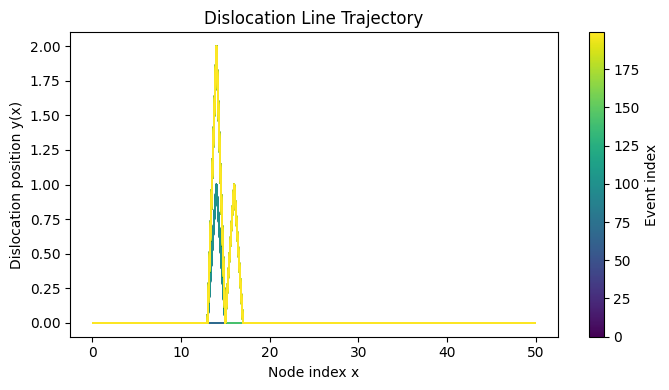

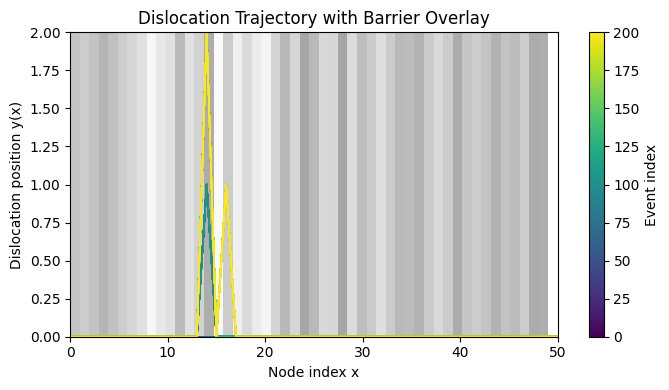

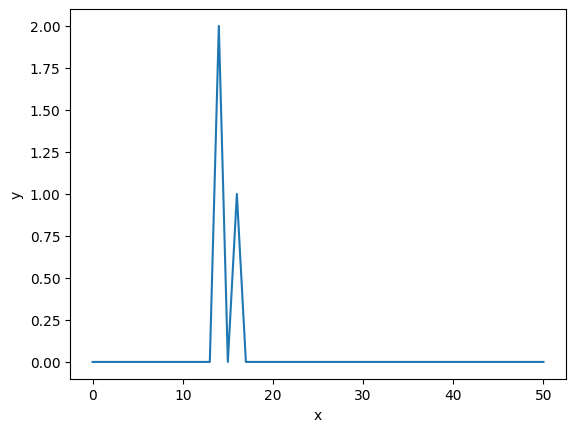

y min/max: 0.0 2.0


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm

kB = 8.617333262e-5  # eV/K

def arrhenius_rate(barrier, T, tau0=1e-12, stress=0.0, Omega=0.0):
    eff = barrier - stress * Omega
    return (1.0 / tau0) * np.exp(-eff / (kB * T))

def sample_barriers(N, mu, sigma):
    return np.random.normal(mu, sigma, size=N)

def propagate_kink(
    y,
    node,
    Gp,
    T,
    stress,
    b,
    Omega_p=0.5
):
    N = len(y) - 1
    Gp_eff = Gp - stress * Omega_p
    Gp_min = np.min(Gp_eff)

    # Right
    for j in range(node, N):
        p_continue = np.exp(-(Gp_eff[j] - Gp_min) / (kB * T))
        if np.random.rand() < p_continue:
            y[j+1] += b
        else:
            break

    # Left
    for j in range(node-1, -1, -1):
        p_continue = np.exp(-(Gp_eff[j] - Gp_min) / (kB * T))
        if np.random.rand() < p_continue:
            y[j] += b
        else:
            break

    print("p_continue range:",
      p_continue.min(), p_continue.max())




def simulate_line_option3(
    N=50,
    b=1.0,
    T=300,
    stress=0.1,
    mu_n=0.2,
    sig_n=0.1,
    mu_p=0.05,
    sig_p=0.05,
    steps=300
):
    # Geometry
    x = np.arange(N+1)

    # Barriers
    Gn = sample_barriers(N+1, mu_n, sig_n)
    Gp = sample_barriers(N,   mu_p, sig_p)

    # Nucleation rates
    lambda_n = arrhenius_rate(Gn, T, stress=stress, Omega=1.0)

    # Line state
    y = np.zeros(N+1)

    # Storage
    y_snapshots = []
    event_times = []

    time = 0.0

    for step in range(steps):
        # Choose nucleation site
        probs = lambda_n / np.sum(lambda_n)
        node = np.random.choice(N+1, p=probs)

        # Nucleation waiting time
        tn = np.random.exponential(1.0 / lambda_n[node])
        time += tn

        # Propagate kink
        propagate_kink(y, node, Gp, T, stress, b)

        # Record
        y_snapshots.append(y.copy())
        event_times.append(time)

    return {
        "x": x,
        "y_snapshots": np.array(y_snapshots),
        "event_times": np.array(event_times),
        "Gn": Gn,
        "Gp": Gp
    }

def plot_line_trajectory_colored(x, y_snapshots):
    segments = []
    colors = []

    for k in range(len(y_snapshots)):
        pts = np.column_stack((x, y_snapshots[k]))
        segments.append(pts)
        colors.append(k)

    lc = LineCollection(
        segments,
        cmap="viridis",
        linewidths=1.2
    )
    lc.set_array(np.array(colors))

    plt.figure(figsize=(7,4))
    plt.gca().add_collection(lc)
    plt.autoscale()

    plt.xlabel("Node index x")
    plt.ylabel("Dislocation position y(x)")
    plt.title("Dislocation Line Trajectory")

    cbar = plt.colorbar(lc)
    cbar.set_label("Event index")

    plt.tight_layout()
    plt.show()

def plot_line_with_barrier_background(x, y_snapshots, Gn):
    fig, ax = plt.subplots(figsize=(7,4))

    ax.imshow(
        Gn[np.newaxis, :],
        extent=[x.min(), x.max(),
                y_snapshots.min(), y_snapshots.max()],
        aspect="auto",
        cmap="Greys",
        alpha=0.35,
        origin="lower"
    )

    for k in range(len(y_snapshots)):
        ax.plot(
            x,
            y_snapshots[k],
            color=cm.viridis(k / len(y_snapshots)),
            linewidth=1.1
        )

    ax.set_xlabel("Node index x")
    ax.set_ylabel("Dislocation position y(x)")
    ax.set_title("Dislocation Trajectory with Barrier Overlay")

    cbar = plt.colorbar(
        cm.ScalarMappable(
            cmap="viridis",
            norm=plt.Normalize(0, len(y_snapshots))
        ),
        ax=ax
    )
    cbar.set_label("Event index")

    plt.tight_layout()
    plt.show()


data = simulate_line_option3(
    N=50,
    T=300,
    stress=0.1,
    steps=200
)

plot_line_trajectory_colored(
    data["x"],
    data["y_snapshots"]
)

plot_line_with_barrier_background(
    data["x"],
    data["y_snapshots"],
    data["Gn"]
)

# Final line should move everywhere
plt.plot(data["x"], data["y_snapshots"][-1])
plt.xlabel("x"); plt.ylabel("y"); plt.show()

# Roughness
print("y min/max:",
      data["y_snapshots"][-1].min(),
      data["y_snapshots"][-1].max())

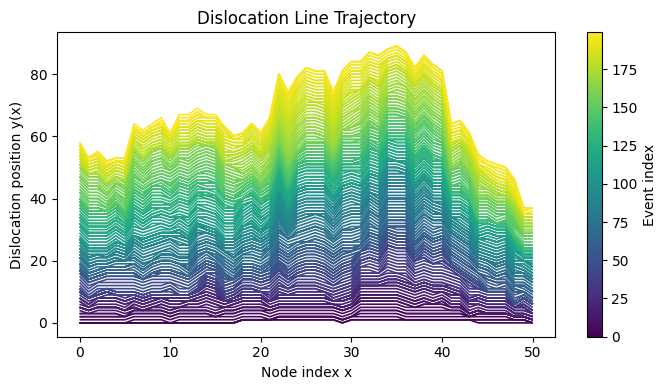

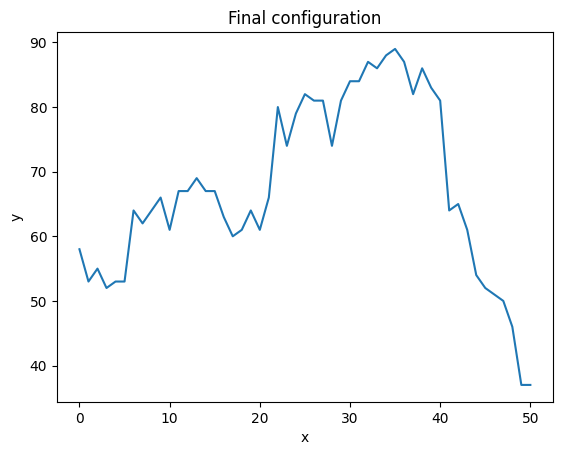

Final y min/max: 37.0 89.0


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm

# -----------------------------
# Constants
# -----------------------------
kB = 8.617333262e-5  # eV/K

# -----------------------------
# Rates
# -----------------------------
def arrhenius_rate(barrier, T, tau0=1e-12):
    return (1.0 / tau0) * np.exp(-barrier / (kB * T))


# -----------------------------
# Barrier sampling
# -----------------------------
def sample_barriers(N, mu, sigma):
    return np.clip(np.random.normal(mu, sigma, size=N), 1e-3, None)


# -----------------------------
# Curvature-based nucleation barrier
# -----------------------------
def effective_nucleation_barrier(Gn, y, alpha=0.5):
    curvature = np.zeros_like(y)
    curvature[1:-1] = np.abs(y[2:] - 2*y[1:-1] + y[:-2])
    return np.clip(Gn - alpha * curvature, 1e-4, None)


# -----------------------------
# Local propagation
# -----------------------------
def propagate_kink(y, node, Gp, T, stress, b, Omega_p=0.5):
    N = len(y) - 1
    Gp_eff = Gp - stress * Omega_p
    Gp_ref = np.median(Gp_eff)

    # Right
    for j in range(node, N):
        delta = Gp_eff[j] - Gp_ref
        p_stop = 1.0 - np.exp(-max(delta, 0.0) / (kB * T))
        if np.random.rand() < p_stop:
            break
        y[j+1] += b

    # Left
    for j in range(node-1, -1, -1):
        delta = Gp_eff[j] - Gp_ref
        p_stop = 1.0 - np.exp(-max(delta, 0.0) / (kB * T))
        if np.random.rand() < p_stop:
            break
        y[j] += b


# -----------------------------
# Main simulation
# -----------------------------
def simulate_line(
    N=50,
    b=1.0,
    T=300,
    stress=0.2,
    mu_n=0.2,
    sig_n=0.1,
    mu_p=0.05,
    sig_p=0.05,
    steps=300,
    alpha=0.5
):
    x = np.arange(N+1)

    Gn = sample_barriers(N+1, mu_n, sig_n)
    Gp = sample_barriers(N,   mu_p, sig_p)

    y = np.zeros(N+1)

    y_snapshots = []
    event_times = []
    time = 0.0

    for step in range(steps):
        # --- Update nucleation barriers and rates ---
        Gn_eff = effective_nucleation_barrier(Gn, y, alpha=alpha)
        lambda_n = arrhenius_rate(Gn_eff, T)

        probs = lambda_n / np.sum(lambda_n)
        node = np.random.choice(N+1, p=probs)

        tn = np.random.exponential(1.0 / lambda_n[node])
        time += tn

        propagate_kink(y, node, Gp, T, stress, b)

        y_snapshots.append(y.copy())
        event_times.append(time)

    return {
        "x": x,
        "y_snapshots": np.array(y_snapshots),
        "event_times": np.array(event_times),
        "Gn": Gn,
        "Gp": Gp
    }


# -----------------------------
# Visualization
# -----------------------------
def plot_line_trajectory_colored(x, y_snapshots):
    segments = []
    colors = []

    for k in range(len(y_snapshots)):
        segments.append(np.column_stack((x, y_snapshots[k])))
        colors.append(k)

    lc = LineCollection(segments, cmap="viridis", linewidths=1.2)
    lc.set_array(np.array(colors))

    plt.figure(figsize=(7,4))
    plt.gca().add_collection(lc)
    plt.autoscale()
    plt.xlabel("Node index x")
    plt.ylabel("Dislocation position y(x)")
    plt.title("Dislocation Line Trajectory")
    plt.colorbar(lc, label="Event index")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Run
# -----------------------------
data = simulate_line(
    N=50,
    T=2200,
    stress=0.1,
    steps=200
)

plot_line_trajectory_colored(
    data["x"],
    data["y_snapshots"]
)

plt.plot(data["x"], data["y_snapshots"][-1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Final configuration")
plt.show()

print("Final y min/max:",
      data["y_snapshots"][-1].min(),
      data["y_snapshots"][-1].max())


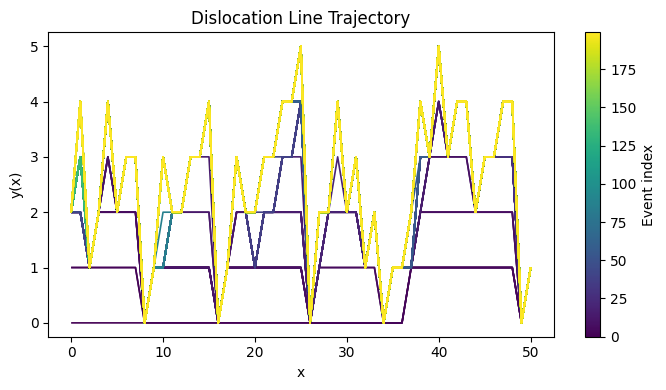

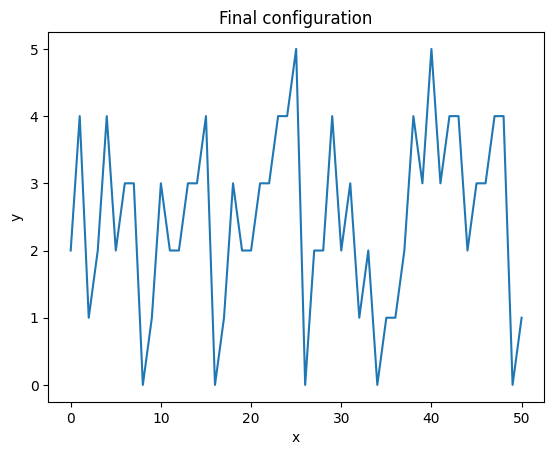

Final y min/max: 0.0 5.0


In [30]:
### Now, adding some form of line tension


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm

kB = 8.617333262e-5  # eV/K

# -----------------------------
# Utilities
# -----------------------------
def arrhenius_rate(barrier, T, tau0=1e-12):
    return (1.0 / tau0) * np.exp(-barrier / (kB * T))

def sample_barriers(N, mu, sigma):
    return np.clip(np.random.normal(mu, sigma, size=N), 1e-3, None)

def curvature(y, dx=1.0):
    c = np.zeros_like(y)
    c[1:-1] = (y[2:] - 2*y[1:-1] + y[:-2]) / dx**2
    return np.abs(c)

# -----------------------------
# Nucleation barrier with line tension
# -----------------------------
def effective_nucleation_barrier(Gn, y, Gamma_n, dx=1.0):
    return np.clip(
        Gn + Gamma_n * curvature(y, dx),
        1e-4,
        None
    )

# -----------------------------
# Propagation with line tension
# -----------------------------
def propagate_kink(
    y,
    node,
    Gp,
    T,
    stress,
    b,
    Gamma_p,
    dx=1.0,
    Omega_p=0.5
):
    N = len(y) - 1
    curv = curvature(y, dx)

    # reference barrier (typical pinning)
    Gp_ref = np.median(Gp)

    # Right
    for j in range(node, N):
        G_eff = (
            Gp[j]
            + Gamma_p * curv[j]
            - stress * Omega_p
        )

        delta = max(G_eff - Gp_ref, 0.0)
        p_stop = 1.0 - np.exp(-delta / (kB * T))

        if np.random.rand() < p_stop:
            break

        y[j+1] += b

    # Left
    for j in range(node-1, -1, -1):
        G_eff = (
            Gp[j]
            + Gamma_p * curv[j]
            - stress * Omega_p
        )

        delta = max(G_eff - Gp_ref, 0.0)
        p_stop = 1.0 - np.exp(-delta / (kB * T))

        if np.random.rand() < p_stop:
            break

        y[j] += b

# -----------------------------
# Main simulation
# -----------------------------
def simulate_line(
    N=50,
    b=1.0,
    dx=1.0,
    T=300,
    stress=0.1,
    mu_n=0.2,
    sig_n=0.1,
    mu_p=0.05,
    sig_p=0.05,
    Gamma_n=0.5,
    Gamma_p=0.1,
    steps=300
):
    x = np.arange(N+1) * dx

    Gn = sample_barriers(N+1, mu_n, sig_n)
    Gp = sample_barriers(N,   mu_p, sig_p)

    y = np.zeros(N+1)

    y_snapshots = []
    event_times = []
    time = 0.0

    for step in range(steps):
        # --- Nucleation ---
        Gn_eff = effective_nucleation_barrier(
            Gn, y, Gamma_n, dx
        )
        lambda_n = arrhenius_rate(Gn_eff, T)

        probs = lambda_n / np.sum(lambda_n)
        node = np.random.choice(N+1, p=probs)

        tn = np.random.exponential(1.0 / lambda_n[node])
        time += tn

        # --- Propagation ---
        propagate_kink(
            y, node, Gp, T, stress, b,
            Gamma_p, dx
        )

        y_snapshots.append(y.copy())
        event_times.append(time)

    return {
        "x": x,
        "y_snapshots": np.array(y_snapshots),
        "event_times": np.array(event_times),
        "Gn": Gn,
        "Gp": Gp
    }

# -----------------------------
# Visualization
# -----------------------------
def plot_line_trajectory_colored(x, y_snapshots):
    segments = []
    colors = []

    for k in range(len(y_snapshots)):
        segments.append(np.column_stack((x, y_snapshots[k])))
        colors.append(k)

    lc = LineCollection(segments, cmap="viridis", linewidths=1.2)
    lc.set_array(np.array(colors))

    plt.figure(figsize=(7,4))
    plt.gca().add_collection(lc)
    plt.autoscale()
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Dislocation Line Trajectory")
    plt.colorbar(lc, label="Event index")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Run
# -----------------------------
data = simulate_line(
    N=50,
    Gamma_n=0.2,
    Gamma_p=0.2,
    stress=0.1,
    steps=200
)

plot_line_trajectory_colored(
    data["x"],
    data["y_snapshots"]
)

plt.plot(data["x"], data["y_snapshots"][-1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Final configuration")
plt.show()

print("Final y min/max:",
      data["y_snapshots"][-1].min(),
      data["y_snapshots"][-1].max())
